# Thermal images augmentation

In [53]:
import json
import os
import torch
import random
import numpy as np
import skimage
import xml.etree.ElementTree as ET
import torchvision.transforms.functional as FT
import matplotlib.pyplot as plt
from PIL import Image
import torch
import random
import numpy as np
import skimage
import torchvision.transforms.functional as FT
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [54]:
def thermal_depth_image_preprocessing(image, split, bbox=None):
    '''
    Simple preprocessing for thermal images

    :param image: array image (h, w, c)
    :param bbox: box coordinates of the object in the image (TODO : allow mutliple boxes)
    :return: torch tensor of shape (2, w, h) and float32 type
    '''
    # Standardization
    mean = np.mean(image, axis=(0, 1))
    std = np.std(image, axis=(0, 1))
    new_img = (image - mean) / std
    new_img = new_img.astype('float32')
    new_bbox = bbox

    if split == 'TRAIN':
        new_img, new_bbox = data_augmentation(new_img, bbox.squeeze().tolist())
        new_bbox = torch.FloatTensor(new_bbox).unsqueeze(0)

    # Reshape to (2, 300, 300)
    new_img = skimage.transform.resize(new_img, (300, 300))
    new_img = np.moveaxis(new_img, -1, 0)
    print(new_img.shape)
    new_img = torch.FloatTensor(new_img)
    

    if bbox is not None:
        old_dims = torch.FloatTensor([image.shape[1], image.shape[0], image.shape[1], image.shape[0]]).unsqueeze(0)
        new_bbox = new_bbox / old_dims  # percent coordinates
        return new_img, new_bbox
    return new_img

def data_augmentation(image, bbox):

    augmenters = [iaa.Crop(percent=(0, 0.2)),
                  iaa.Affine(rotate=(-30, 30)),
                  iaa.AdditiveGaussianNoise(scale=0.05 * np.max(image[0])),
                  #iaa.ElasticTransformation(alpha=(0, 20.0), sigma=(4.0, 6.0)),
                  iaa.Dropout(p=(0.0, 0.1)),
                  iaa.Fliplr(1.0)]

    # 50 tries (in case the silhouette is too much outside the rotated image)
    for i in range(50):
        seq = iaa.SomeOf((0, 3), augmenters, random_order=True)
        image_aug, bbs_aug = seq(image=image, bounding_boxes=BoundingBox(*bbox))

        bbs_clipped = bbs_aug.clip_out_of_image(image_aug)
        # Si on crop plus de 20% d'une bbox lors du clip_out_of_image(), on recommence.
        if bbs_clipped.area / bbs_aug.area > 0.8:
            break

    return image_aug, (bbs_clipped.x1, bbs_clipped.y1, bbs_clipped.x2, bbs_clipped.y2)

(60, 80, 1)


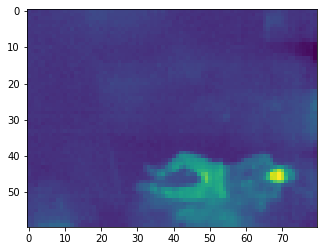

In [55]:
image = Image.open('/home/mathurin/prudence/data_no_fusion/Serie_18/Thermique/thermal1.png', mode='r')
image = np.expand_dims(np.array(image), axis=-1)
print(image.shape)
plt.imshow(image[:, :, 0])


(1, 300, 300)


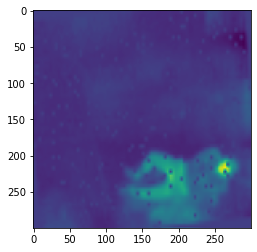

(1, 300, 300)


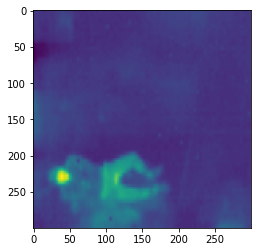

(1, 300, 300)


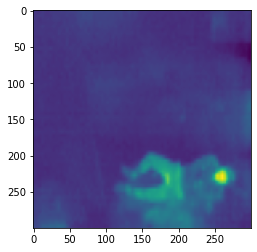

(1, 300, 300)


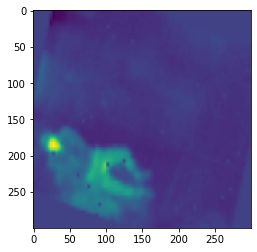

(1, 300, 300)


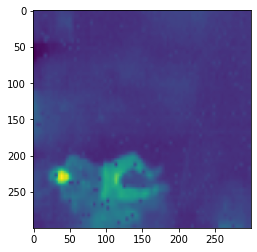

(1, 300, 300)


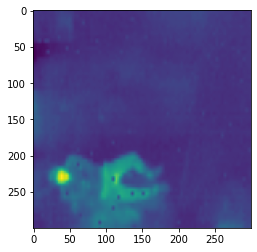

(1, 300, 300)


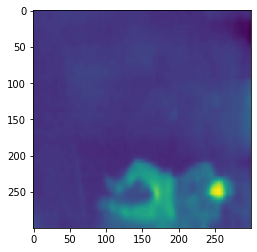

(1, 300, 300)


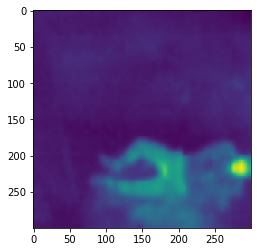

(1, 300, 300)


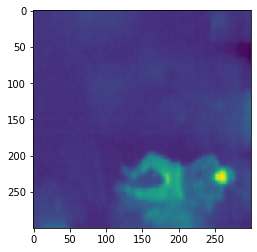

(1, 300, 300)


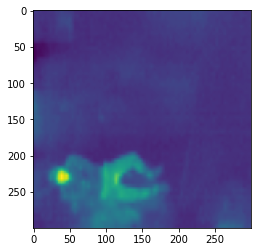

(1, 300, 300)


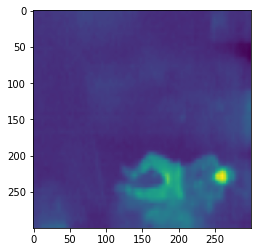

(1, 300, 300)


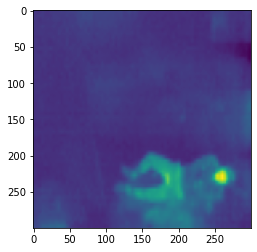

(1, 300, 300)


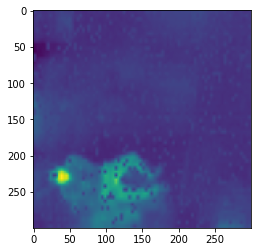

(1, 300, 300)


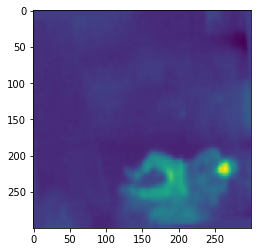

(1, 300, 300)


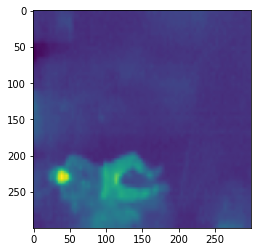

(1, 300, 300)


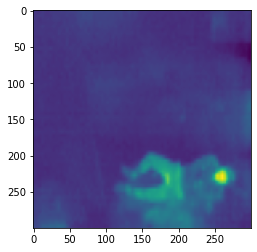

(1, 300, 300)


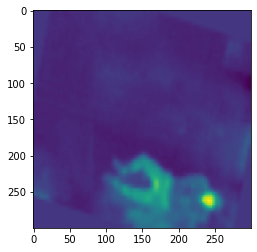

(1, 300, 300)


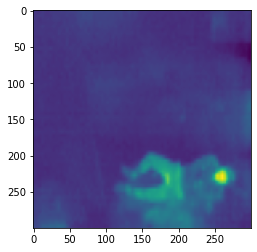

(1, 300, 300)


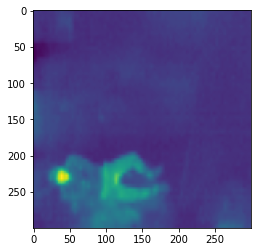

(1, 300, 300)


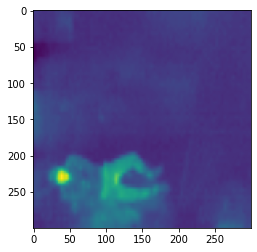

In [56]:
for i in range(20):
    boxe = torch.FloatTensor([27, 37, 80, 57])
    new_image, new_boxe = thermal_depth_image_preprocessing(image,"TRAIN",  boxe)

    plt.imshow(np.array(new_image)[0, :, :])
    plt.show()